In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Generating Monet Style Images with GANs

This project is part of the following Kaggle competition (https://www.kaggle.com/competitions/gan-getting-started/overview). The goal of this project is to utilize a Generative Adversarial Network (GAN) to create images in the style of the painter Monet. This is done by using a set of real photograph images and an additional set of monet painting images as training data. The model will then generate new versions of the real images as if they were painted by Monet.

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import PIL

## Data

This project utilizes two core data sets, both provided by the Kaggle competition. First is a set of real photograph jpg files, which we will store as PHOTO_FILENAMES, and second is a set of Monet jpg files, which we will read in as MONET_FILENAMES.

We will then create functions to decode the images and load them into datasets that we will use for our model.

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str('/kaggle/input/gan-getting-started/monet_jpg/*.jpg'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str('/kaggle/input/gan-getting-started/photo_jpg/*.jpg'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 300
Photo TFRecord Files: 7038


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
def decode_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

def load_dataset(path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(path)
    dataset = dataset.shuffle(buffer_size = 1000).map(decode_image, num_parallel_calls = AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    return dataset

## Convolutions

Our GAN model will consist of a Generator to generate Monet-style images and a Discriminator to distinguish the generated images from the real Monet images. The generator and discriminator will rely on two seperate functions defined here as conv_down and conv_up. These functions will utilize Conv2D or Conv2DTranspose to transform the image input, either reducing the image (conv_down) or increasing (conv_up).

In [ ]:
def conv_down(x, num_filters, size, padding = 'same', strides = '2', norm = True):
    x = keras.layers.Conv2D(
        num_filters,
        size,
        padding = padding,
        strides = strides
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(negative_slope = 0.2)(x)

    return x

In [ ]:
def conv_up(x, num_filters, size, padding = 'same', strides = '2', act = True, drop = False):
    x = keras.layers.Conv2DTranspose(
        num_filters,
        size,
        padding = padding,
        strides = strides
    )(x)

    if drop == True:
        x = keras.layers.Dropout(0.3)(x)
    
    if act == True:
        x = keras.layers.LeakyReLU(negative_slope = 0.2)(x)
        

    return x
    
    

## Generator

The generator model will be used to generate new Monet-style images. It takes in a 256, 256, 3 image, such as our real photograph images, and outputs a newly generated image. The model uses a series of conv_down layers to encode the original image, followed by a series of conv_up layers to generate the new Monet-style image. Skip-connections are added in between each layer. The final output is a new 256, 256, 3 image.

In [ ]:
def generator():
    input = keras.layers.Input(shape = [256,256,3])

    skips = []
    

    x = conv_down(input, 32, size = 4, strides = 2) #128
    skips.append(x)
    x = conv_down(x, 64, size = 4, strides = 2) #64
    skips.append(x)
    x = conv_down(x, 128, size = 4, strides = 2) #32
    skips.append(x)
    x = conv_down(x, 256, size = 4, strides = 2) #16
    skips.append(x)

    x = conv_up(x, 256, size = 4, strides = 2 ) #32
    x = keras.layers.concatenate([x, skips[-2]])
    x = conv_up(x, 128, size = 4, strides = 2 ) #64
    x = keras.layers.concatenate([x, skips[-3]])
    x = conv_up(x, 64, size = 4, strides = 2 ) #128
    x = keras.layers.concatenate([x, skips[-4]])
    x = conv_up(x, 32, size = 4, strides = 2 ) #256
   

    x = conv_up(x, 3, size = 5, strides = 1, act = False)
    fake = keras.layers.Activation('tanh')(x)

    return tf.keras.Model(inputs = input, outputs = fake)

## Discriminator

The discriminator model is used to evaluate the generated images with the goal of identifying images that have been generated by the generator. This then challenges the generator to create more accurate images. The discriminator model takes in a 256, 256, 3 image. The model includes a series of convolutional layers followed by a dense layer that will indicate he classification of real or generated.

In [ ]:
def discriminator():
    input = keras.layers.Input(shape = [256, 256, 3])

    x = conv_down(input, 32, size = 4, strides = 2)
    x = conv_down(x, 64, size = 4, strides = 2)
    x = conv_down(x, 128, size = 4, strides = 2)
    x = conv_down(x, 256, size = 4, strides = 2)

    #x = keras.layers.Conv2D(1, 4, strides=1)(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1)(x)

    return tf.keras.Model(inputs = input, outputs = x )

    

## Training

We will first define a function called train_step, to run our training process. This function will take in both of our data sets, as well as both the generator and discriminator models. It will then run training steps for each model. 

To train the discriminator, fake images are first generated with the generator. The discriminator is then given both the real monet images and the fake, generated images to classify. Loss for both the evaluation of fake and real images is calculated and then combined to create a single loss value for the discriminator. This loss is then used to caculate a gradient and update the discriminator model. To create a strong discriminator model, this process is ran twice for every step, helping ensure it remains able to successfully discriminate against the generator.

The generator is then trained by once again creating fake images and giving them to the discriminator. Loss is calculated based on the images determined to be fake by the discriminator and the generator is updated using the gradient.

In [ ]:
def train_step(photo_data, monet_data, gen_optimizer, d_optimizer, gen_model, d_model):
    

    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True, label_smoothing = 0.1)

    for i in range (2):
        with tf.GradientTape(persistent = True) as d_tape:
            fake_images = gen_model(photo_data, training = True)
        
            d_real = d_model(monet_data, training = True)
            d_fake = d_model(fake_images, training =True)
            
            d_loss_fake = loss(tf.zeros_like(d_fake), d_fake)
            d_loss_real = loss(tf.ones_like(d_real), d_real)
            d_loss_total = d_loss_fake + d_loss_real
    
            d_grad = d_tape.gradient(d_loss_total, d_model.trainable_variables)
            d_optimizer.apply_gradients(zip(d_grad, d_model.trainable_variables))
    
    with tf.GradientTape(persistent = True) as gen_tape:
        fake_images = gen_model(photo_data, training = True)
        
        d_real = d_model(monet_data, training = True)
        d_fake = d_model(fake_images, training =True)

        gen_loss = loss(tf.ones_like(d_fake), d_fake)

        gen_grad = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
        gen_optimizer.apply_gradients(zip(gen_grad, gen_model.trainable_variables))




    return d_loss_total, gen_loss
        
    

In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

Here we will instantiate our models, load in our datasets using our previous functions, and loop through the training process given a set number of epochs.

In [ ]:
epochs = 50
gen_model = generator()
d_model = discriminator()

batch_size = 1
monet_dataset = load_dataset(MONET_FILENAMES,batch_size)
photo_dataset = load_dataset(PHOTO_FILENAMES, batch_size)


for epoch in range(0, epochs):

    d_loss = 0
    gen_loss = 0
    
    for monet_batch, photo_batch in zip(monet_dataset, photo_dataset):
        d_loss_new, gen_loss_new = train_step(photo_batch, monet_batch, gen_optimizer, d_optimizer,gen_model, d_model)
        d_loss += d_loss_new
        gen_loss += gen_loss_new

    print(epoch)
    print('d_loss: ', d_loss)
    print('gen_loss: ', gen_loss)

    

## Saving and Loading Models

In [6]:
#gen_model.save('/kaggle/working/gen_model.h5')
gen_model = tf.keras.models.load_model('/kaggle/working/gen_model.h5')

#d_model.save('/kaggle/working/d_model.h5')
d_model = tf.keras.models.load_model('/kaggle/working/d_model.h5')

## Visualizing Results

In [7]:
batch_size = 1
monet_dataset = load_dataset(MONET_FILENAMES,batch_size)
photo_dataset = load_dataset(PHOTO_FILENAMES, batch_size)

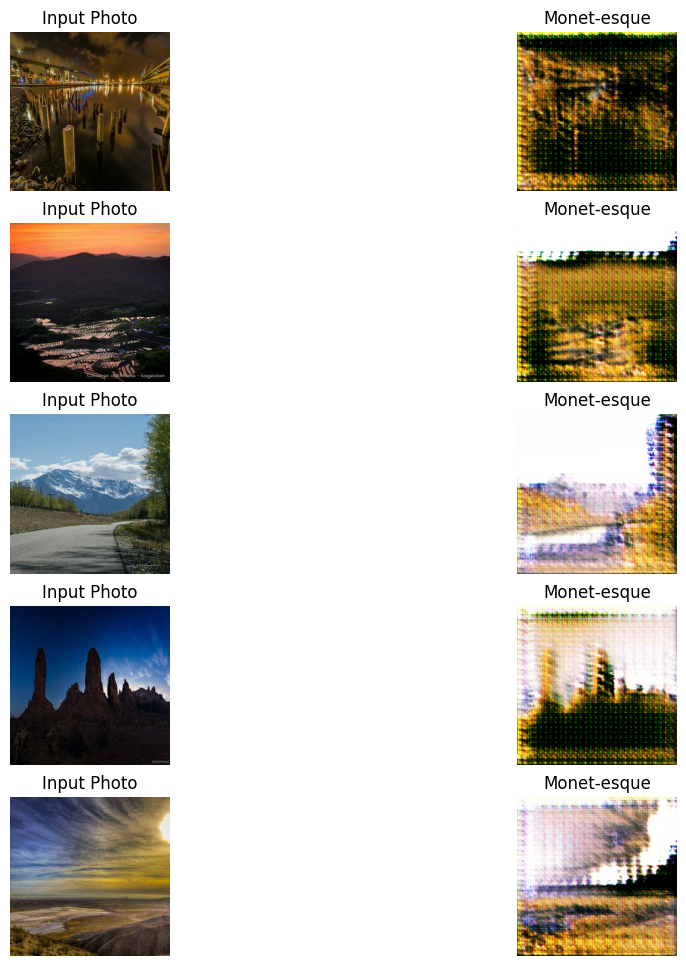

In [10]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_dataset.take(5)):
    # prediction = gen_model(img, training=False)[0].numpy()
    # prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    prediction = gen_model.predict(img, verbose = 0)
    prediction = (prediction[0] * 127.5 + 127.5).astype(np.uint8)
    
    
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Saving Output for Kaggle Competition

In [ ]:
path = "/kaggle/working/images/"

if not os.path.exists(path):
    os.mkdir(path)

In [ ]:
i = 1
for img in photo_dataset:
    prediction = gen_model.predict(img, verbose = 0)
    prediction = (prediction[0] * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(path + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")


## Conclusion

From looking at some of the sample images generated, you can tell that the GAN does appear to be making images that represent the original image, but are clearly altered in a way that somewhat resembles an impressionist style painting, such as Monet. The model could still use some improvement, as the images do not look exactly like a painting. More training time might help, as well as some alterations to the model. I submitted the model, with a few different variations, to the Kaggle competition, and with a best score of 169.8.

In the future, this model could be improved, however, it does demonstrate how a basic GAN model can generate images approximating a certain art style.